In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal

In [2]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

In [8]:
program = cl.Program(ctx, """
    uint rand_int(__global uint *seed) {
        return (*seed = 1103515245**seed + 12345);
    }

    float rand_uniform(__global uint *seed) {
        return (float)rand_int(seed)/(float)0xffffffff;
    }
    
    bool is_inside(int2 p, int2 l, int2 h) {
        return l.x <= p.x && p.x < h.x && l.y <= p.y && p.y < h.y;
    }

    __kernel void a_move(
        __global int *a_agents, __global uint *a_random,
        __global float *w_tracks, __constant int *w_size
    ) {
        int gi = get_global_id(0);
        int gs = get_global_size(0);
        int2 ws = vload2(0, w_size);

        int2 pos = vload2(gi, a_agents);
        int d = rand_int(&(a_random[gi])) % 5;
        pos += (d != 0)*(int2)((d%2)*(2-d), ((d+1)%2)*(3-d));
        pos = clamp(pos, (int2)(0, 0), ws - (int2)(1,1));
        vstore2(pos, gi, a_agents);
        
        uint p = (pos.x + ws.x*pos.y);
        w_tracks[p] = 1.0;
    }
    
    __kernel void w_fade(
        __global float *w_tracks
    ) {
        int2 gi = (int2)(get_global_id(0), get_global_id(1));
        int2 gs = (int2)(get_global_size(0), get_global_size(1));
        int p = (gi.x + gs.x*gi.y);
        w_tracks[p] *= 0.999;
    }

    __kernel void w_draw(
        __global const float *w_tracks, __global uchar *w_screen
    ) {
        int2 gi = (int2)(get_global_id(0), get_global_id(1));
        int2 gs = (int2)(get_global_size(0), get_global_size(1));
        int p = (gi.x + gs.x*gi.y);
        uchar c = (uchar)(255*w_tracks[p]);
        uchar3 col = (uchar3)(c, c, 0);
        vstore3(col, p, w_screen);
    }

    __kernel void a_draw(
        __global const int *a_agents, __global uchar *w_screen, __constant int *w_size
    ) {
        int gi = get_global_id(0);
        int gs = get_global_size(0);
        int2 ws = vload2(0, w_size);

        int2 pos = vload2(gi, a_agents);
        int p = (pos.x + ws.x*pos.y);
        uchar c = 255;
        uchar3 col = (uchar3)(c, c, c);
        vstore3(col, p, w_screen);
    }
""").build()

In [9]:
class World:
    def __init__(self, size, n_agents):
        self.w_size = size
        self.w_npshape = (size[1], size[0])
        self.a_size = (n_agents,)
        self.a_npshape = (n_agents,)
        
        self.gw_size = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np.array(self.w_size, dtype=np.int32))
        
        self.cw_screen = np.zeros((*self.w_npshape, 3), dtype=np.uint8)
        self.gw_screen = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=self.cw_screen)
        
        self.ca_random = np.random.randint(1<<32, size=self.a_npshape, dtype=np.uint32)
        self.ga_random = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=self.ca_random)
        
        self.cw_tracks = np.zeros(self.w_npshape, dtype=np.float32)
        self.gw_tracks = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=self.cw_tracks)
        
        ax = np.random.randint(0, self.w_size[0], size=self.a_npshape)
        ay = np.random.randint(0, self.w_size[1], size=self.a_npshape)
        self.ca_agents = np.stack((ax, ay), axis=1).astype(np.int32)
        
        self.ga_agents = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=self.ca_agents)
        
        self.prog = program
        
    def step(self):
        self.prog.w_fade(queue, self.w_size, None, self.gw_tracks)
        self.prog.a_move(queue, self.a_size, None, self.ga_agents, self.ga_random, self.gw_tracks, self.gw_size)
        
    def draw(self):
        self.prog.w_draw(queue, self.w_size, None, self.gw_tracks, self.gw_screen)
        self.prog.a_draw(queue, self.a_size, None, self.ga_agents, self.gw_screen, self.gw_size)
        cl.enqueue_copy(queue, self.cw_screen, self.gw_screen)
        return Image.fromarray(self.cw_screen)

In [18]:
world = World((1920, 1080), 1024)

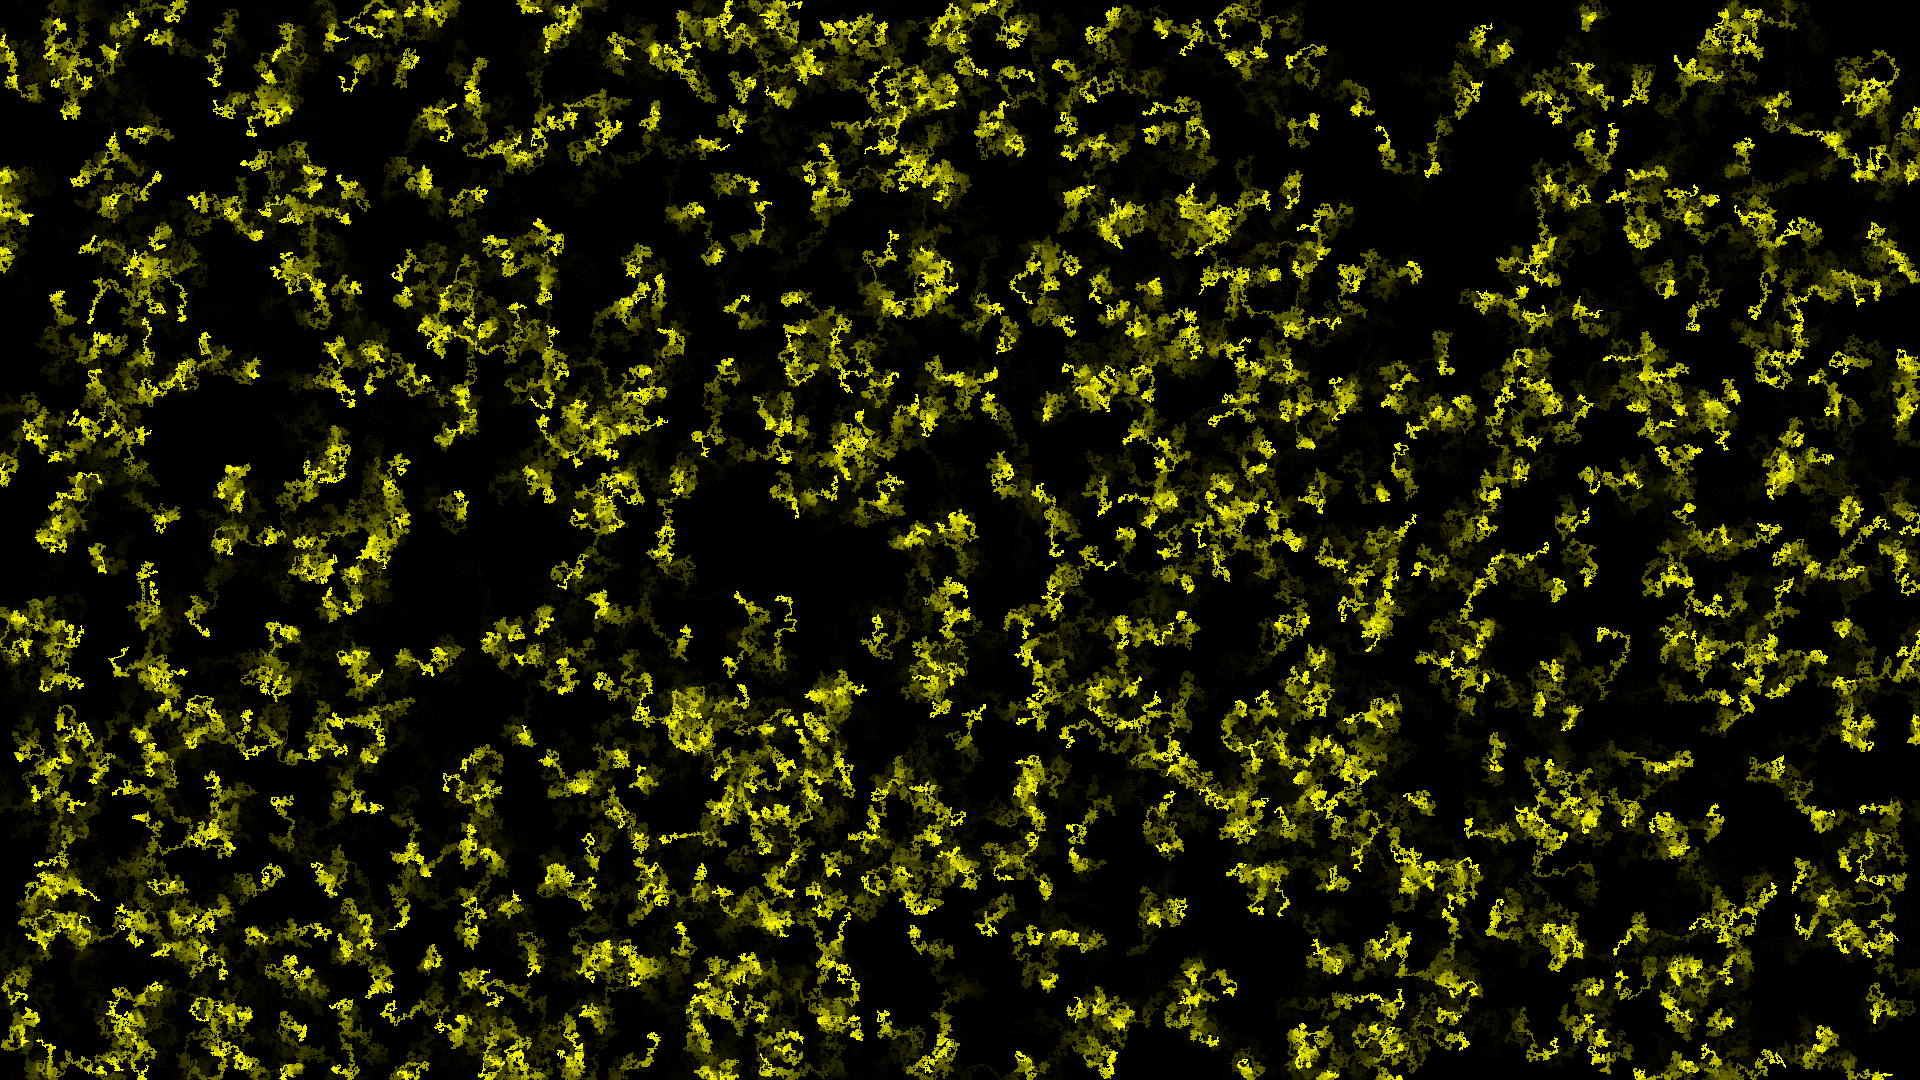

steps elapsed: 62178


In [19]:
stop_on_signal()
last = time.time()
n_steps = 0
while not signal_done:
    world.step()
    n_steps += 1
    now = time.time()
    if now - last >= 5.0:
        clear_output(wait=True)
        display(world.draw())
        print("steps elapsed: %s" % n_steps)
        last = now

In [ ]:
world.step()
cl.enqueue_copy(queue, world.ca_agents, world.ga_agents)
print(world.ca_agents)